In [2]:
from pathlib import Path

import matplotlib.pyplot as plt
import nibabel as nib
import numpy as np
import pandas as pd

# from brats.utils import show_mri

In [3]:
INPUT_ADNI_DIR = Path('../data/raw/ADNI')

img_fpaths = list(INPUT_ADNI_DIR.glob('**/*.nii'))
len(img_fpaths)

0

In [67]:
def parse_XML(xml_file, df_cols): 
    """Parse the input XML file and store the result in a pandas 
    DataFrame with the given columns. 
    
    The first element of df_cols is supposed to be the identifier 
    variable, which is an attribute of each node element in the 
    XML data; other features will be parsed from the text content 
    of each sub-element. 
    """
    
    xtree = et.parse(xml_file)
    xroot = xtree.getroot()
    rows = []
    
    for node in xroot: 
        res = []
        res.append(node.attrib.get(df_cols[0]))
        for el in df_cols[1:]: 
            if node is not None and node.find(el) is not None:
                res.append(node.find(el).text)
            else: 
                res.append(None)
        rows.append({df_cols[i]: res[i] 
                     for i, _ in enumerate(df_cols)})
    
    out_df = pd.DataFrame(rows, columns=df_cols)
        
    return out_df

In [22]:
from lxml import objectify

fp = next(INPUT_ADNI_DIR.glob('ADNI_*.xml'))
print(fp)
xml_data = objectify.parse(str(fp))  # Parse XML data
root = xml_data.getroot().getchildren()[0]  # Root element

data = []
cols = []
for i in range(len(root.getchildren())):
    child = root.getchildren()[i]
    data.append([subchild.text for subchild in child.getchildren()])
    cols.append(child.tag)

df = pd.DataFrame(data).T  # Create DataFrame and transpose it
df.columns = cols  # Update column names
print(df)

../data/raw/ADNI1/ADNI_012_S_0634_MPR____N3__Scaled_S15751_I64585.xml
  projectIdentifier projectDescription siteKey     subject
0              None               None    None  012_S_0634
1              None               None    None         MCI
2              None               None    None           M
3              None               None    None           3
4              None               None    None           3
5              None               None    None        None
6              None               None    None        None


In [39]:
sid_image = list()
for img_fpath in INPUT_ADNI_DIR.glob('**/*.nii'):
    s = str(img_fpath.name).rstrip('.nii')
    sid_image.append({
        'subject': s[5:15],
        'series': s.split('_')[-2],
        'image': s.split('_')[-1],
    })
d = pd.DataFrame(sid_image)
d.groupby('subject')['series'].unique().apply(len).sort_values()

subject
002_S_0295    1
094_S_0921    1
094_S_1015    1
094_S_1027    1
094_S_1090    1
             ..
018_S_0633    2
116_S_1083    2
023_S_0031    2
051_S_1131    2
130_S_0449    3
Name: series, Length: 818, dtype: int64

In [45]:
d.groupby('subject')['image'].unique().apply(len).sort_values().tail(10)

subject
068_S_0442    4
068_S_0476    4
136_S_0426    4
136_S_0300    4
136_S_0299    4
023_S_1262    4
023_S_1289    4
023_S_1104    4
023_S_1046    4
067_S_0607    5
Name: image, dtype: int64

In [30]:
data_dict['ns0:idaxs']['project']['subject']['researchGroup']

'MCI'

In [110]:
import xml.etree.ElementTree as ET
import xmltodict

metas = list()
for fp in INPUT_ADNI_DIR.glob('ADNI_*.xml'):
    tree = ET.parse(str(fp))
    xml_data = tree.getroot()

    xmlstr = ET.tostring(xml_data, encoding='utf-8', method='xml')

    data_dict = dict(xmltodict.parse(xmlstr))
    
    meta = {
    }

    visit = data_dict['ns0:idaxs']['project']['subject']['visit']
    mmse = cdr = np.nan
    try:
        for assm in visit['assessment']:
            if assm['@name'] == 'MMSE':
                mmse = float(assm['component']['assessmentScore']['#text'])
            if assm['@name'] == 'CDR':
                cdr = float(assm['component']['assessmentScore']['#text'])
    except KeyError:
        pass

    metas.append({
        'subject': data_dict['ns0:idaxs']['project']['subject']['subjectIdentifier'],
        'group': data_dict['ns0:idaxs']['project']['subject']['researchGroup'],
        'age': data_dict['ns0:idaxs']['project']['subject']['study']['subjectAge'],
        'mmse': mmse,
        'cdr': cdr,
        'visit_identifier': visit['visitIdentifier'],
#         'series': data_dict['ns0:idaxs']['project']['subject']['study']['series']['studyIdentifier'],
    })
#     except KeyError:
#         pass
    
#     if metas[-1]['visit_identifier'] == 'ADNI Baseline':
#         break
m = pd.DataFrame(metas).sort_values(by=['subject', 'age'])
m

,subject,group,age,mmse,cdr,visit_identifier
76,002_S_0413,CN,76.4329,NaN,NaN,ADNI Baseline
93,002_S_0413,CN,76.4329,NaN,NaN,ADNI Baseline
429,002_S_0413,CN,76.926,29.0,0.0,ADNI1/GO Month 6
221,002_S_0413,CN,77.4685,29.0,0.0,ADNI1/GO Month 12
31,002_S_0413,CN,78.6356,30.0,0.0,ADNI1/GO Month 24
...,...,...,...,...,...,...
415,136_S_1227,MCI,64.7068,NaN,NaN,ADNI Baseline
386,136_S_1227,MCI,65.2603,28.0,0.5,ADNI1/GO Month 6
94,136_S_1227,MCI,65.7452,30.0,0.5,ADNI1/GO Month 12
111,136_S_1227,MCI,66.3123,29.0,0.5,ADNI1/GO Month 18


In [111]:
m['cdr_progress'] = m['cdr'] - m['cdr'].shift(1)
m[m['cdr_progress'] < 0]

,subject,group,age,mmse,cdr,visit_identifier,cdr_progress
292,012_S_0689,AD,64.6904,17.0,0.5,ADNI1/GO Month 12,-0.5
408,023_S_0030,MCI,81.5863,23.0,0.5,ADNI1/GO Month 18,-0.5
213,023_S_0625,MCI,77.0932,17.0,0.5,ADNI1/GO Month 12,-0.5
185,067_S_0607,MCI,79.9808,28.0,-1.0,ADNI1/GO Month 18,-1.5
8,136_S_0086,CN,82.4548,30.0,-1.0,ADNI1/GO Month 24,-1.0
343,136_S_0300,AD,58.5123,26.0,0.5,ADNI1/GO Month 24,-0.5
302,136_S_0579,MCI,67.6384,30.0,0.0,ADNI1/GO Month 24,-0.5


In [113]:
m.groupby('subject')['group'].nunique().sort_values()

subject
002_S_0413    1
100_S_0190    1
100_S_0015    1
067_S_0607    1
053_S_0507    1
             ..
023_S_0031    1
023_S_0030    1
018_S_0633    1
023_S_0604    1
136_S_1227    1
Name: group, Length: 86, dtype: int64

In [103]:
m['_subject_number'] = m.subject.str.replace('_S_','').astype(int)
m

,subject,group,age,mmse,cdr,visit_identifier,_subject_number
66,002_S_0413,CN,76.4329,NaN,NaN,ADNI Baseline,20413
80,002_S_0413,CN,76.4329,NaN,NaN,ADNI Baseline,20413
346,002_S_0413,CN,76.926,29.0,0.0,ADNI1/GO Month 6,20413
177,002_S_0413,CN,77.4685,29.0,0.0,ADNI1/GO Month 12,20413
25,002_S_0413,CN,78.6356,30.0,0.0,ADNI1/GO Month 24,20413
...,...,...,...,...,...,...,...
316,136_S_0429,MCI,63.3151,28.0,0.5,ADNI1/GO Month 6,1360429
132,136_S_0429,MCI,63.8137,25.0,0.5,ADNI1/GO Month 12,1360429
146,136_S_0429,MCI,64.3123,26.0,0.5,ADNI1/GO Month 18,1360429
215,136_S_0429,MCI,64.8137,25.0,0.5,ADNI1/GO Month 24,1360429


In [94]:
data_dict

{'ns0:idaxs': {'@xmlns:ns0': 'http://ida.loni.usc.edu',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  '@xsi:schemaLocation': '/xsds/idaxs_2_0.xsd',
  'project': {'projectIdentifier': 'ADNI',
   'projectDescription': "Alzheimer's Disease Neuroimaging Initiative",
   'siteKey': '023',
   'subject': {'subjectIdentifier': '023_S_0331',
    'researchGroup': 'MCI',
    'subjectSex': 'F',
    'subjectInfo': [{'@item': 'APOE A1', '#text': '4'},
     {'@item': 'APOE A2', '#text': '4'}],
    'visit': {'visitIdentifier': 'ADNI Baseline',
     'assessment': [{'@name': 'Neuropsychiatric Inventory-Questionnaire (NPI-Q)',
       'component': {'@name': 'Neuropsychiatric Inventory Q - Total Score',
        'assessmentScore': {'@attribute': 'NPISCORE', '#text': '3.0'}}},
      {'@name': 'Functional Assessment Questionnaire',
       'component': {'@name': 'FAQ Total score',
        'assessmentScore': {'@attribute': 'FAQTOTAL', '#text': '9.0'}}}]},
    'study': {'studyIdentifier': '3502',

In [98]:
m[m['subject'] == '027_S_1082']

,subject,group,age,mmse,cdr,visit_identifier
131,027_S_1082,AD,69.6438,NaN,NaN,ADNI Baseline
244,027_S_1082,AD,70.1178,20.0,1.0,ADNI1/GO Month 6
4,027_S_1082,AD,70.6219,10.0,1.0,ADNI1/GO Month 12
287,027_S_1082,AD,71.6329,5.0,2.0,ADNI1/GO Month 24


In [60]:
mmse_minmax = m.groupby(['subject', 'group'])['mmse'].agg([min, max])
mmse_minmax

,,min,max
subject,group,,
002_S_0295,CN,28.0,28.0
002_S_0413,CN,24.0,29.0
002_S_0559,CN,25.0,30.0
002_S_0619,AD,22.0,22.0
002_S_0685,CN,30.0,30.0
...,...,...,...
941_S_1202,CN,28.0,28.0
941_S_1203,CN,30.0,30.0
941_S_1295,MCI,28.0,28.0


In [61]:
mmse_minmax.groupby('group')['min'].min()

group
AD     18.0
CN     21.0
MCI    20.0
Name: min, dtype: float64

In [52]:
data_dict

{'ns0:idaxs': {'@xmlns:ns0': 'http://ida.loni.usc.edu',
  '@xmlns:xsi': 'http://www.w3.org/2001/XMLSchema-instance',
  '@xsi:schemaLocation': '/xsds/idaxs_2_0.xsd',
  'project': {'projectIdentifier': 'ADNI',
   'projectDescription': "Alzheimer's Disease Neuroimaging Initiative",
   'siteKey': '114',
   'subject': {'subjectIdentifier': '114_S_0601',
    'researchGroup': 'CN',
    'subjectSex': 'F',
    'subjectInfo': [{'@item': 'APOE A1', '#text': '3'},
     {'@item': 'APOE A2', '#text': '3'}],
    'visit': {'visitIdentifier': 'ADNI Screening',
     'assessment': [{'@name': 'MMSE',
       'component': {'@name': 'MMSE Total Score',
        'assessmentScore': {'@attribute': 'MMSCORE', '#text': '30.0'}}},
      {'@name': 'GDSCALE',
       'component': {'@name': 'GDS Total Score',
        'assessmentScore': {'@attribute': 'GDTOTAL', '#text': '1.0'}}},
      {'@name': 'CDR',
       'component': {'@name': 'CDR Total Score',
        'assessmentScore': {'@attribute': 'CDGLOBAL', '#text': '0.0'}

In [51]:
m.groupby('subject')['group'].unique().apply(len).sort_values()

subject
002_S_0295    1
098_S_0288    1
098_S_0667    1
098_S_0884    1
098_S_0896    1
             ..
029_S_0843    1
029_S_0845    1
029_S_0866    1
027_S_1082    1
941_S_1363    1
Name: group, Length: 818, dtype: int64

In [21]:
xml_data = objectify.parse(str(fp))  # Parse XML data
root = xml_data.getroot()  # Root element

root.getchildren()

[<Element project at 0x7f3629838e10>]

In [5]:
pd.read_xml(next(INPUT_ADNI_DIR.glob('ADNI_*.xml')))



AttributeError: module 'pandas' has no attribute 'read_xml'

In [ ]:
pd.read_xml(INPUT_ADNI_DIR)

In [21]:
OUTPUT_ADNI_DIR = Path('../data/raw/ADNI23_prep')

len(list(OUTPUT_ADNI_DIR.glob('*.nii')))

4731

In [9]:
list(OUTPUT_ADNI_DIR.glob('*.nii'))[0].name.split('__')[0].split('_S_')[1]

'1379'

In [22]:
import pickle
with open(OUTPUT_ADNI_DIR/'groups.pkl', 'rb') as f:
    adni23_groups = pickle.load(f)

In [23]:
import pickle
with open(Path('../data/raw/ADNI1_prep')/'groups.pkl', 'rb') as f:
    adni1_groups = pickle.load(f)

In [28]:
pd.Series(dict(adni23_groups, **adni1_groups).values()).value_counts()

CN         1913
EMCI       1307
MCI        1143
AD          733
LMCI        664
SMC         240
Patient       5
dtype: int64

In [27]:
pd.Series(adni23_groups.values()).value_counts()

CN         1546
EMCI       1307
LMCI        664
MCI         521
AD          448
SMC         240
Patient       5
dtype: int64

In [13]:
order_labels = np.array(['CN', 'EMCI', 'LMCI', 'MCI', 'AD', 'SMC'])

In [20]:
np.where(order_labels == 'Patient')[0][0]

IndexError: index 0 is out of bounds for axis 0 with size 0

In [80]:
import pickle

with open(OUTPUT_ADNI_DIR/'ages.pkl', 'rb') as f:
    ages = pickle.load(f)
len(ages.keys())

4731

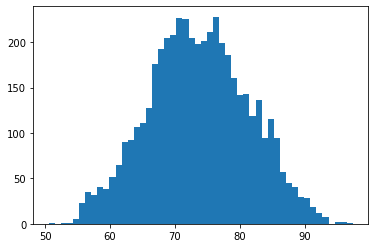

In [85]:
plt.hist(np.array(list(ages.values())), bins=50)
plt.show()

In [79]:
pd.Series(groups).value_counts()

CN         1546
EMCI       1307
LMCI        664
MCI         521
AD          448
SMC         240
Patient       5
dtype: int64

In [75]:
list(OUTPUT_ADNI_DIR.glob('*.pkl'))

[PosixPath('../data/raw/ADNI23_prep/ages.pkl'),
 PosixPath('../data/raw/ADNI23_prep/groups.pkl')]

In [73]:
all_fpaths = list(OUTPUT_ADNI_DIR.glob(f"*.nii"))

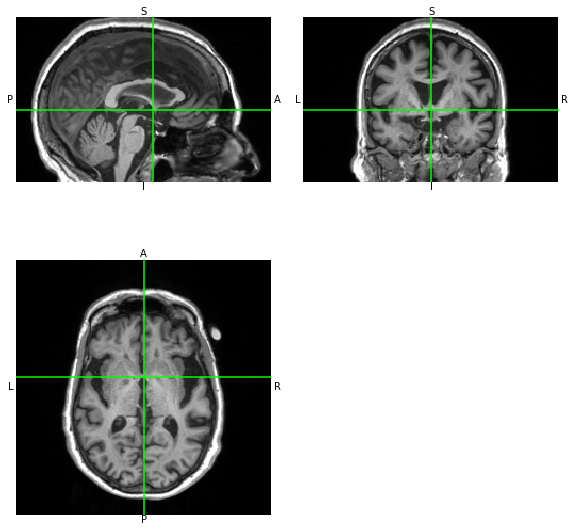

In [74]:
show_mri(np.random.choice(all_fpaths), pos=(0,0,0))

In [6]:
sids = np.array(list({path.name.split('__')[0] for path in OUTPUT_ADNI_DIR.glob(f"*.nii")}))
len(sids)

0

In [100]:
import h5py

with h5py.File('../data/interim/ADNI123_slices_fix_2mm_split.hdf5', 'r') as h:
    print(h['train']['X'].shape)
#     X_new = h['3']['X'][50*40 + 20]
# plt.imshow(X_new, cmap='gray')
# plt.show()

(61760, 96, 96)


40360


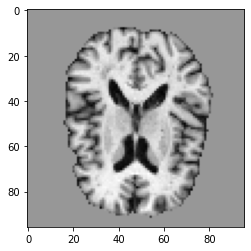

In [14]:
import h5py
import matplotlib.pyplot as plt


ys = list()
with h5py.File('../data/interim/ADNI23_slices_fix_2mm_5fold.hdf5', 'r') as h:
    print(len(h['0']['X'])+len(h['1']['X'])+len(h['2']['X'])+len(h['3']['X']))
    X_new = h['3']['X'][50*40 + 20]
#     print(h.keys())
    for i in range(5):
# #     print(h['0']['X'].shape)
        ys.append(h[str(i)]['y'][:])
    
#     i = np.random.randint(h['0']['y'].shape[0])
    
#     print(h['0']['y'][i])
#     plt.imshow(h['0']['X'][i], cmap='gray')
ys = np.hstack(ys)

plt.imshow(X_new, cmap='gray')
plt.show()

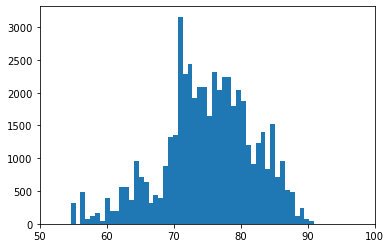

In [5]:
plt.hist(ys, bins=50)
plt.xlim(50,100)
plt.show()

In [6]:
np.abs(ys - np.ones(ys.shape) * np.median(ys)).mean()

5.437596235769322

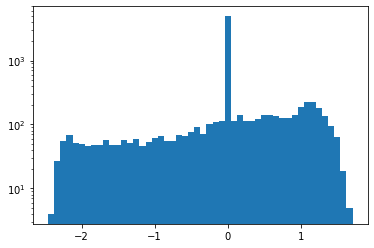

In [15]:
plt.hist(X_new.flatten(), bins=50)
plt.yscale('log')
plt.show()

64240


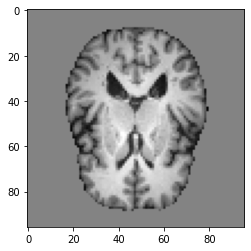

In [12]:
import h5py
import matplotlib.pyplot as plt

with h5py.File('../data/interim/ADNI_slices_fix_2mm_split.hdf5', 'r') as h:
    print(len(h['train']['X']))
    X_old = h['train']['X'][50*40 + 20]
    ys = h['train']['y'][:]
#     print(h.keys())
#     for i in range(5):
# #     print(h['0']['X'].shape)
#         print(h[str(i)]['y'][:].min())
    
#     i = np.random.randint(h['0']['y'].shape[0])
    
#     print(h['0']['y'][i])
#     plt.imshow(h['0']['X'][i], cmap='gray')

plt.imshow(X_old, cmap='gray')
plt.show()

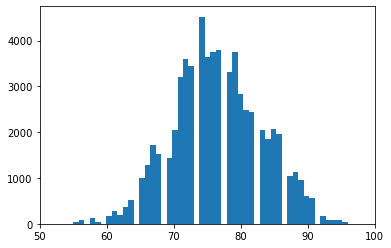

In [9]:
plt.hist(ys, bins=50)
plt.xlim(50,100)
plt.show()

In [10]:
np.abs(ys - np.ones(ys.shape) * np.median(ys)).mean()

5.326899128268991

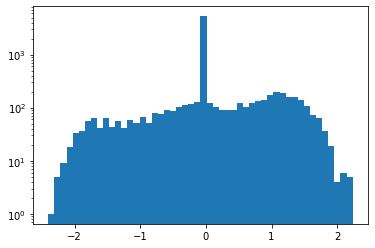

In [13]:
plt.hist(X_old.flatten(), bins=50)
plt.yscale('log')
plt.show()

In [54]:
with h5py.File('../data/interim/ADNI_slices_fix_2mm_split.hdf5', 'r') as h:
    print(h['val']['y'][:].max())


92


In [202]:
(9920+10280+10320+9840+10600) / 40

1274.0

In [143]:
from sklearn.model_selection import KFold

In [190]:
splitter = KFold(5, shuffle=True, random_state=42)
all_folds_sids = list()
for train_ix, test_ix in splitter.split(sids):
    train_sids, test_sids = sids[train_ix], sids[test_ix]
    all_folds_sids += list(test_sids)

In [158]:
test_fpaths = [path for path in OUTPUT_ADNI_DIR.glob(f"*.nii") if path.name.split('__')[0] in test_sids]
len(test_fpaths) / len(all_fpaths)

0.19623233908948196

In [159]:
train_fpaths = [path for path in OUTPUT_ADNI_DIR.glob(f"*.nii") if path.name.split('__')[0] in train_sids]
len(train_fpaths) / len(all_fpaths)

0.8037676609105181

76 images were discarded.

files damaged:

- 0: /data/slow/ADNI/094_S_1241/MP-RAGE/2008-05-08_13_49_43.0/S50440/ADNI_094_S_1241_MR_MP-RAGE__br_raw_20080521101110638_1_S50440_I106320.nii
- 1: /data/slow/ADNI/100_S_0069/Sagittal_3D_Accelerated_MPRAGE/2019-01-23_13_17_50.0/S787747/ADNI_100_S_0069_MR_Sagittal_3D_Accelerated_MPRAGE_br_raw_20190124004844579_1_S787747_I1119606.nii
- 3: /data/slow/ADNI/002_S_4262/MPRAGE/2012-01-02_13_27_48.0/S135052/ADNI_002_S_4262_MR_MPRAGE_br_raw_20120103095051041_19_S135052_I274823.nii
- 4: /data/slow/ADNI/137_S_0972/MP-RAGE/2008-12-02_15_06_48.0/S60444/ADNI_137_S_0972_MR_MP-RAGE__br_raw_20081203083427360_1_S60444_I129029.nii
- 6: /data/slow/ADNI/007_S_1222/MP-RAGE/2008-02-22_08_51_18.0/S46098/ADNI_007_S_1222_MR_MP-RAGE__br_raw_20080223113756555_1_S46098_I91633.nii
- 7: /data/slow/ADNI/022_S_4266/MPRAGE/2012-03-06_13_16_45.0/S143253/ADNI_022_S_4266_MR_MPRAGE_br_raw_20120308154812534_159_S143253_I289098.nii


# Preprocessing

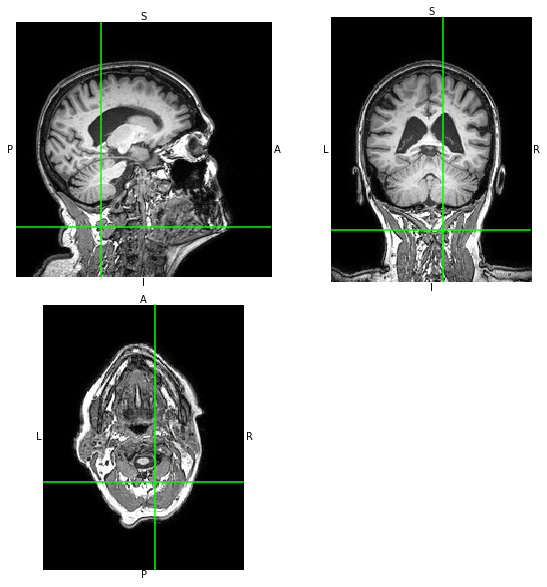

In [60]:
from brats.utils import show_mri

show_mri(np.random.choice(list(Path(INPUT_ADNI_DIR).glob('**/*.nii'))), pos=(250,250,500))

In [22]:
import re
import xml.etree.ElementTree as ET

age = 0
for f in Path(INPUT_ADNI_DIR).glob('**/*.nii'):
    match = re.search(r"(?P<image_id>I[0-9]+)\.nii", f.name)
    if not match:
        print(f.name)
    meta_fpath = next(Path(INPUT_ADNI_DIR).glob(f"*{match['image_id']}.xml"))
    if not meta_fpath.exists():
        print(f.name)
        break
    tree = ET.parse(meta_fpath)
    age += float(tree.find('project').find('subject').find('study').find('subjectAge').text)

In [26]:
for f in Path(INPUT_ADNI_DIR).glob('**/*.nii'):
    match = re.search(r"(?P<image_id>I[0-9]+)\.nii", f.name)
    if not match:
        print(f.name)
    if len(list(Path(INPUT_ADNI_DIR).glob(f"*{match['image_id']}.xml"))) != 1:
        print(f)
        break

78.6822


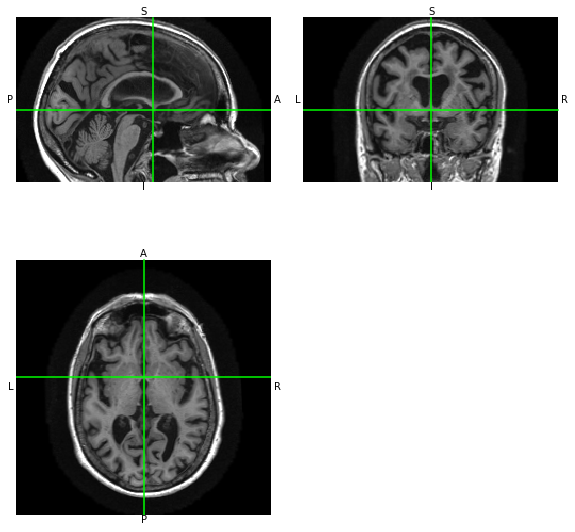

In [109]:
img_fpath = np.random.choice(list(Path(OUTPUT_ADNI_DIR).glob('**/*.nii')))

print(ages[img_fpath.name.split('__')[1].replace('.nii', '')])

show_mri(img_fpath, pos=(0,0,0))

In [131]:
from sklearn.model_selection import KFold

splits = KFold(5, shuffle=True, random_state=42)
splits

KFold(n_splits=5, random_state=42, shuffle=True)

In [132]:
list(splits.split(np.arange(10)))

[(array([0, 2, 3, 4, 5, 6, 7, 9]), array([1, 8])),
 (array([1, 2, 3, 4, 6, 7, 8, 9]), array([0, 5])),
 (array([0, 1, 3, 4, 5, 6, 8, 9]), array([2, 7])),
 (array([0, 1, 2, 3, 5, 6, 7, 8]), array([4, 9])),
 (array([0, 1, 2, 4, 5, 7, 8, 9]), array([3, 6]))]

In [91]:
ids = set()
i = 0
for img_fpath in Path(INPUT_ADNI_DIR).glob('**/*.nii'):
    local_fpath = str(img_fpath).lstrip(str(INPUT_ADNI_DIR))
    subject_id = local_fpath.split('/')[0]

    image_id = img_fpath.name.split('_')[-1][:-4]

    ids.add(image_id)
    i += 1

In [17]:
import xml.etree.ElementTree as ET

tree = ET.parse(meta_fpath)
float(tree.find('project').find('subject').find('study').find('subjectAge').text)

76.0329

In [19]:
tree.find('project').find('subject').find('researchGroup').text

'MCI'

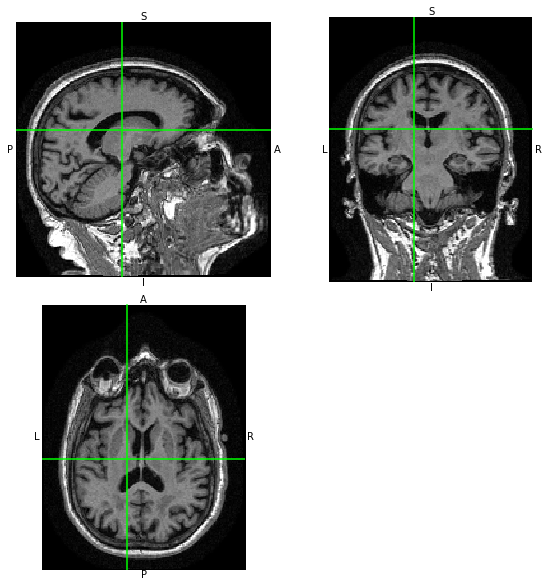

In [4]:
from brats.utils import show_mri
from brats.preprocessing.nipype_wrappers import ants_registration, ants_transformation

img_fpath = np.random.choice(list(Path(INPUT_ADNI_DIR).glob('**/*.nii')))

img = nib.load(img_fpath)

# show_mri(img, pos=tuple(img.affine[:3,3] + np.array(img.shape) / 2))
show_mri(img, pos=(0,0,0))

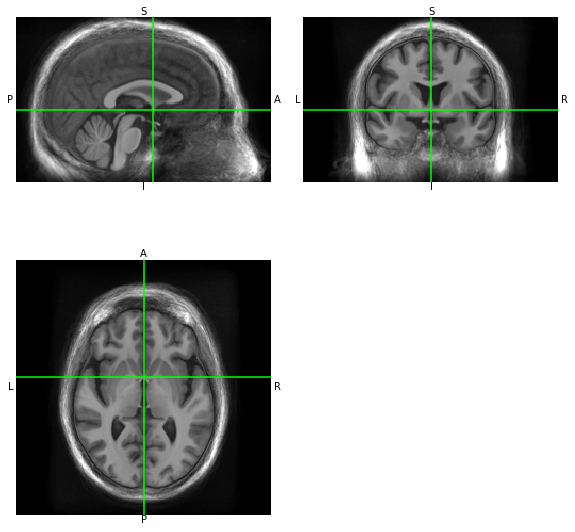

In [5]:
template_fpath = Path('../data/external/SRI24_T1.nii')

show_mri(template_fpath, pos=(0,0,0))

In [6]:
reg_transform, _ = ants_registration(str(template_fpath), str(img_fpath), '.tmpdir/reg_')
reg_transform

'/home/jupyter/gama/bruno/notebooks/.tmpdir/reg_0GenericAffine.mat'

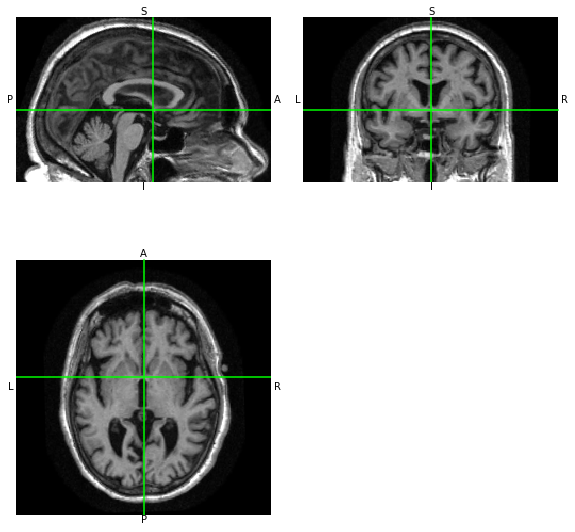

In [7]:
sri_img_fpath = ants_transformation(img_fpath, template_fpath, [reg_transform,], '.tmpdir/sri24_')

show_mri(sri_img_fpath, pos=(0,0,0))

In [197]:
local_fpath = str(img_fpath).lstrip(str(Path('/data/slow/ADNI')))
subject_id = local_fpath.split('/')[0]

image_id = img_fpath.name.split('_')[-1][:-4]

In [198]:
subject_id, image_id

('035_S_0156', 'I89963')

In [202]:
df[(df['Subject'] == subject_id) & (df['Image Data ID'] == image_id)].iloc[0]

Image Data ID        I89963
Subject          035_S_0156
Group                    CN
Sex                       M
Age                      76
Visit                     6
Modality                MRI
Description          MPRAGE
Type               Original
Acq Date          2/07/2008
Format                  DCM
Downloaded        4/12/2022
Name: 1559, dtype: object

# Preprocessed data

In [223]:
!ls ../data/raw/ADNI_prep

002_S_0295__I114210__87.nii   041_S_0125__I135066__77.nii
002_S_0295__I13722__85.nii    041_S_0125__I167380__78.nii
002_S_0295__I144446__88.nii   041_S_0125__I20211__74.nii
002_S_0295__I144447__88.nii   041_S_0125__I37809__75.nii
002_S_0295__I173732__89.nii   041_S_0125__I37810__75.nii
002_S_0295__I238627__90.nii   041_S_0125__I89019__76.nii
002_S_0295__I28561__85.nii    041_S_0125__I9924__74.nii
002_S_0295__I303066__91.nii   041_S_0262__I101894__88.nii
002_S_0295__I55275__86.nii    041_S_0262__I12137__86.nii
002_S_0413__I114997__79.nii   041_S_0262__I12139__86.nii
002_S_0413__I1221051__90.nii  041_S_0262__I142333__89.nii
002_S_0413__I143221__79.nii   041_S_0262__I170756__90.nii
002_S_0413__I14437__76.nii    041_S_0262__I170762__90.nii
002_S_0413__I173460__80.nii   041_S_0262__I35070__87.nii
002_S_0413__I240812__82.nii   041_S_0262__I52148__87.nii
002_S_0413__I29705__77.nii    041_S_0898__I132134__85.nii
002_S_0413__I304793__82.nii   041_S_0898__I158501__86.nii
002_S_0413__I371991__83.

(240, 240, 155)
[[   1.    0.   -0. -120.]
 [   0.    1.   -0. -129.]
 [   0.    0.    1.  -68.]
 [   0.    0.    0.    1.]]


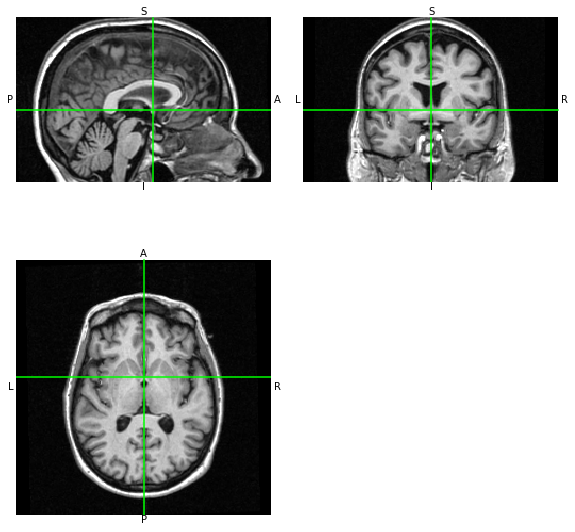

In [5]:
img_fpath = np.random.choice(list(Path('/data/slow/ADNI_prep').glob('*.nii')))

img = nib.load(img_fpath)

print(img.shape)
print(img.affine)
show_mri(img, pos=(0,0,0))

(1, 80, 192, 160)


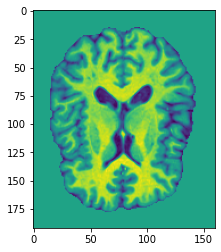

In [52]:
from collections import OrderedDict
from nnunet.preprocessing.preprocessing import PreprocessorFor2D
from batchgenerators.augmentations.utils import pad_nd_image
from brats.preprocessing.hdbet_wrapper import hd_bet

def load_preprocess_for_nnunet(
        img_fpath,
        tmpdir='.tmpdir',
        patch_size=[192, 160],
        input_shape_must_be_divisible_by=[32, 32],
        normalization_schemes=OrderedDict([(0, 'nonCT')]),
        use_mask_for_norm=OrderedDict([(0, True)]),
        transpose_forward=[0, 1, 2],
        intensity_properties=None,
        target_spacing=[1., 1., 1.],
    ):
    brain_img_fpath, _ = hd_bet(img_fpath, tmpdir, mode='fast')

    prep = PreprocessorFor2D(normalization_schemes, use_mask_for_norm,
                                transpose_forward, intensity_properties)
    brain, _, prop = prep.preprocess_test_case([str(brain_img_fpath),], target_spacing)

    # get only slices with meaningful brain info
    crop_lb = prop['crop_bbox'][0][0]
    lb = 35 - crop_lb
    ub = 115 - crop_lb
    brain = brain[:,lb:ub]

    padded_brain, _ = pad_nd_image(
        brain,
        patch_size,
        mode='constant',
        kwargs={'constant_values': 0},
        return_slicer=True,
        shape_must_be_divisible_by=input_shape_must_be_divisible_by,
    )

    return padded_brain

prep_img = load_preprocess_for_nnunet(img_fpath)

print(prep_img.shape)
plt.imshow(prep_img[0,40])

# Split

In [9]:
df = pd.read_csv('dataframe2D-ADNI.csv', index_col=0)
df.head()

,patient,filename,slice,age,dataset,split
0,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,25,70,ADNI,val
1,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,26,70,ADNI,val
2,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,27,70,ADNI,val
3,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,28,70,ADNI,val
4,ADNI_010_S_0419,/home/jupyter/data/ADNI/slices/010_S_0419_10_s...,29,70,ADNI,val


In [10]:
df.groupby('patient')['split'].first()

patient
ADNI_002_S_0295    train
ADNI_002_S_0413    train
ADNI_002_S_0559    train
ADNI_002_S_0685    train
ADNI_002_S_1261    train
                   ...  
ADNI_941_S_6570    train
ADNI_941_S_6574    train
ADNI_941_S_6575      val
ADNI_941_S_6580    train
ADNI_941_S_6581    train
Name: split, Length: 663, dtype: object

In [5]:
df['split'].value_counts()

train    88400
val      20400
Name: split, dtype: int64

In [62]:
train_sids = df[df['split'] == 'train']['patient'].unique()
train_sids

array(['ADNI_130_S_0886', 'ADNI_007_S_6455', 'ADNI_941_S_6580',
       'ADNI_035_S_6730', 'ADNI_130_S_6027', 'ADNI_941_S_6058',
       'ADNI_082_S_4208', 'ADNI_051_S_1123', 'ADNI_003_S_6259',
       'ADNI_006_S_4150', 'ADNI_032_S_4348', 'ADNI_022_S_0014',
       'ADNI_013_S_6780', 'ADNI_114_S_6063', 'ADNI_114_S_6309',
       'ADNI_032_S_4304', 'ADNI_130_S_0232', 'ADNI_073_S_4552',
       'ADNI_068_S_4174', 'ADNI_131_S_6692', 'ADNI_011_S_0008',
       'ADNI_013_S_1276', 'ADNI_082_S_6283', 'ADNI_009_S_0842',
       'ADNI_032_S_6211', 'ADNI_941_S_1203', 'ADNI_100_S_4511',
       'ADNI_114_S_0601', 'ADNI_141_S_1094', 'ADNI_012_S_4642',
       'ADNI_168_S_6492', 'ADNI_032_S_6701', 'ADNI_031_S_4032',
       'ADNI_135_S_4566', 'ADNI_100_S_1286', 'ADNI_052_S_1251',
       'ADNI_041_S_6447', 'ADNI_033_S_6572', 'ADNI_022_S_4320',
       'ADNI_116_S_6750', 'ADNI_082_S_4339', 'ADNI_109_S_6218',
       'ADNI_168_S_6059', 'ADNI_023_S_0963', 'ADNI_073_S_4762',
       'ADNI_094_S_6485', 'ADNI_014_S_40

In [63]:
val_sids = df[df['split'] == 'val']['patient'].unique()
val_sids

array(['ADNI_010_S_0419', 'ADNI_141_S_0726', 'ADNI_130_S_6391',
       'ADNI_137_S_0283', 'ADNI_035_S_6751', 'ADNI_016_S_0359',
       'ADNI_032_S_6294', 'ADNI_018_S_6351', 'ADNI_082_S_6415',
       'ADNI_023_S_6346', 'ADNI_021_S_0647', 'ADNI_023_S_1190',
       'ADNI_128_S_0229', 'ADNI_021_S_0159', 'ADNI_168_S_6285',
       'ADNI_013_S_0502', 'ADNI_114_S_6524', 'ADNI_007_S_6120',
       'ADNI_003_S_6260', 'ADNI_003_S_4644', 'ADNI_007_S_0070',
       'ADNI_099_S_0534', 'ADNI_036_S_6316', 'ADNI_002_S_6009',
       'ADNI_033_S_4179', 'ADNI_072_S_4103', 'ADNI_094_S_0526',
       'ADNI_031_S_0618', 'ADNI_006_S_0484', 'ADNI_023_S_1306',
       'ADNI_036_S_6466', 'ADNI_035_S_4464', 'ADNI_032_S_6717',
       'ADNI_116_S_6517', 'ADNI_023_S_6270', 'ADNI_131_S_0436',
       'ADNI_116_S_6458', 'ADNI_099_S_0040', 'ADNI_036_S_0672',
       'ADNI_137_S_6826', 'ADNI_094_S_6440', 'ADNI_006_S_0681',
       'ADNI_130_S_6111', 'ADNI_941_S_6254', 'ADNI_099_S_4076',
       'ADNI_082_S_6563', 'ADNI_052_S_09

In [71]:
imgs_dir = Path('../data/raw/ADNI_prep')

imgs_fpaths = list(imgs_dir.glob('*.nii'))

len(imgs_fpaths)

2727

In [100]:
train_fpaths_ = [list(imgs_dir.glob(f"{sid[5:]}*.nii")) for sid in train_sids]
train_fpaths = list()
for fs in train_fpaths_:
    train_fpaths += fs

val_fpaths = list(set(imgs_fpaths).difference(set(train_fpaths)))

assert len(val_fpaths) + len(train_fpaths) == len(imgs_fpaths)

len(train_fpaths) / len(imgs_fpaths)

0.8085808580858086

In [101]:
val_fpaths

[PosixPath('../data/raw/ADNI_prep/127_S_0259__I47591__72.nii'),
 PosixPath('../data/raw/ADNI_prep/032_S_1169__I949029__83.nii'),
 PosixPath('../data/raw/ADNI_prep/003_S_6092__I944379__65.nii'),
 PosixPath('../data/raw/ADNI_prep/006_S_0484__I47327__72.nii'),
 PosixPath('../data/raw/ADNI_prep/127_S_0259__I99698__73.nii'),
 PosixPath('../data/raw/ADNI_prep/114_S_0173__I41856__74.nii'),
 PosixPath('../data/raw/ADNI_prep/009_S_4612__I424035__71.nii'),
 PosixPath('../data/raw/ADNI_prep/131_S_0441__I103961__75.nii'),
 PosixPath('../data/raw/ADNI_prep/029_S_0843__I24406__71.nii'),
 PosixPath('../data/raw/ADNI_prep/035_S_0555__I213220__81.nii'),
 PosixPath('../data/raw/ADNI_prep/114_S_0166__I90738__75.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_4213__I573758__82.nii'),
 PosixPath('../data/raw/ADNI_prep/141_S_6416__I1018186__69.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_4225__I297357__71.nii'),
 PosixPath('../data/raw/ADNI_prep/035_S_0156__I497588__84.nii'),
 PosixPath('../data/raw/ADNI_p

In [105]:
val_sids_csv = set([sid[5:] for sid in val_sids])

assert len(val_sids_csv) == len(val_sids)

val_sids_split = set([fp.name.split('__')[0] for fp in val_fpaths])

assert len(val_sids_split) == len(val_sids_csv)
assert len(val_sids_split.intersection(val_sids_csv)) == len(val_sids_csv)

AssertionError: 

In [106]:
len(val_sids_split)

132

In [107]:
len(val_sids_csv)

129

In [108]:
val_sids_split.difference(val_sids_csv)

{'011_S_6714', '035_S_6739', '041_S_0262', '141_S_6178'}

In [109]:
val_sids_csv.difference(val_sids_split)

{'003_S_6257'}

In [149]:
sorted(train_fpaths)

[PosixPath('../data/raw/ADNI_prep/002_S_0295__I114210__87.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I13722__85.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I144446__88.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I144447__88.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I173732__89.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I238627__90.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I28561__85.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I303066__91.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0295__I55275__86.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I114997__79.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I1221051__90.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I143221__79.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I14437__76.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I173460__80.nii'),
 PosixPath('../data/raw/ADNI_prep/002_S_0413__I240812__82.nii'),
 PosixPath('../data/raw/ADNI

In [150]:
train_fpaths

[PosixPath('../data/raw/ADNI_prep/130_S_0886__I119619__73.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I77144__72.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I267862__77.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I48660__72.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_0886__I25455__71.nii'),
 PosixPath('../data/raw/ADNI_prep/007_S_6455__I1011962__68.nii'),
 PosixPath('../data/raw/ADNI_prep/007_S_6455__I1344288__70.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6580__I1343715__82.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6580__I1226810__81.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6580__I1046736__80.nii'),
 PosixPath('../data/raw/ADNI_prep/035_S_6730__I1176653__74.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_6027__I1254168__78.nii'),
 PosixPath('../data/raw/ADNI_prep/130_S_6027__I938631__76.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6058__I1209877__70.nii'),
 PosixPath('../data/raw/ADNI_prep/941_S_6058__I884964__68.nii'),
 PosixPath('../data/

# HDF5 Dataset

In [219]:
import h5py

with h5py.File('testfile.hdf5', 'w') as f:
    train = f.create_group('train')
    X = train.create_dataset('X', (80,192,160), maxshape=(None,192,160), dtype='float32', chunks=(1,192,160))
    y = train.create_dataset('y', (80,), maxshape=(None,), dtype='uint8')

    X[0:80] = prep_img[0]
    y[0:80] = 71

with h5py.File('testfile.hdf5', 'r+') as f:
    X = f['/train/X']
    y = f['/train/y']
    print(X.shape)
    print(y.shape)
    X.resize(X.shape[0]+80, axis=0)
    y.resize(y.shape[0]+80, axis=0)

    X[80:] = prep_img[0]*-1
    y[80:] = 70
    print(X.shape)
    print(y.shape)

(80, 192, 160)
(80,)
(160, 192, 160)
(160,)


In [220]:
with h5py.File('testfile.hdf5', 'r') as f:
    X = f['/train/X']
    y = f['train']['y']
    i0 = X[0]
    y0 = y[0]
    i1 = X[80]
    y1 = y[80]

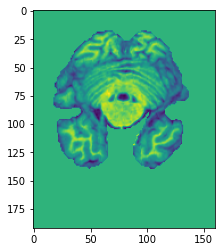

In [208]:
plt.imshow(i0)

In [221]:
y0

71

In [222]:
y1

70

In [218]:
int(img_fpath.name.split('.')[0].split('__')[-1])

71

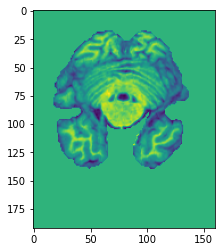

In [209]:
plt.imshow(-1*i1)

In [184]:
with h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r+') as h:
    dset = h['test']
    print(dset.shape)
    data = dset[:]

(480, 192, 160)


In [277]:
with h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r') as h:
    print(h['train']['y'].shape)

(160,)


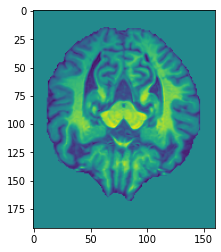

In [196]:
plt.imshow(data[np.random.choice(np.arange(480))])

In [223]:
h = h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r')
h.close()

<HDF5 file "ADNI_slices.hdf5" (mode r)>

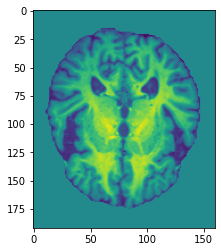

In [234]:
plt.imshow(h['test']['X'][np.random.choice(880)])

In [256]:
h['test']['y'][-2]

0

In [265]:
prep_img[0].shape == (80, 192, 160)

True

In [266]:
img_fpath.unlink

<bound method Path.unlink of PosixPath('/data/slow/ADNI_prep/128_S_0272__I12313__71.nii')>

In [274]:
!ls /home/bruno-pacheco/brain-age/data/raw/ADNI_prep/137_S_6826__I1242424__68.nii

/home/bruno-pacheco/brain-age/data/raw/ADNI_prep/137_S_6826__I1242424__68.nii


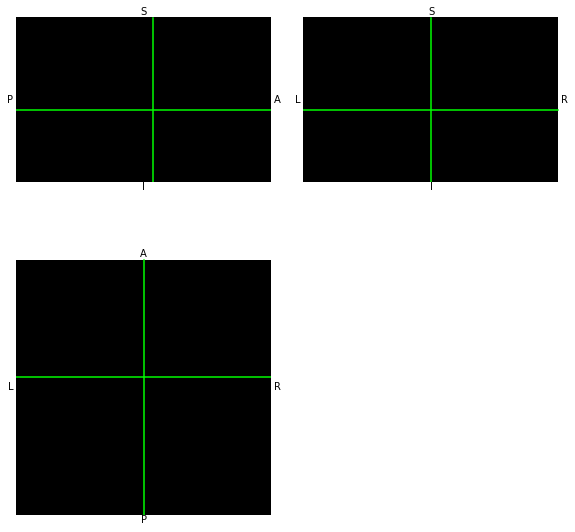

In [292]:
show_mri('/home/bruno-pacheco/brain-age/data/raw/ADNI_prep/168_S_6049__I1348108__76.nii', pos=(0,0,0))

In [332]:
h = h5py.File('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices.hdf5', 'r')

In [295]:
h.keys()

<KeysViewHDF5 ['test', 'train']>

In [310]:
X_train = h['train/X']

X_train[np.random.choice(X_train.shape[0])].shape

(192, 160)

In [348]:
torch.Tensor([h['train/y'][25]])

tensor([76.])

In [349]:
h.close()

In [ ]:
import h5py
from torch.utils.data import Dataset
import torch
from torchvision import transforms
from pathlib import Path

class ADNIDatasetForBraTSModel(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
        split=0,
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        
        assert dataset.lower() in ['train', 'test'], '`dataset` must be either `train` or `test`.'
        self.dataset = dataset.lower()
        self.split = split

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            if self.dataset == 'test':
                l = h[str(self.split)]['y'].shape[0]
            else:
                l = 0
                for i in range(5):
                    if i != self.split:
                        l += h[str(i)]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        if self.dataset == 'train':
            splits = [i for i in range(5) if i != self.split]
            sizes = list()
            for i in splits:
                with h5py.File(self._fpath, 'r') as h:
                    sizes.append(h[str(i)]['y'].shape[0])

            full_len = self.__len__()
            assert sum(sizes) == full_len
            if index >= full_len:
                raise IndexError

            for i, size in enumerate(sizes):
                index = index - size
                split = splits[i]
                if index < 0:
                    break
        else:
            split = self.split

        print(split, index)

        with h5py.File(self._fpath, 'r') as h:
            img = h[str(split)]['X'][index]
            label = h[str(split)]['y'][index]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, label

ds = ADNIDatasetForBraTSModel('../data/interim/ADNI1_slices_fix_2mm_5fold.hdf5', dataset='train', split=0)
len(ds)

In [101]:
torch.rand(20,20).median()

tensor(0.5189)

In [51]:
ds = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='test')
len(ds) / 40

584.0

In [92]:
ds = ADNIDatasetForBraTSModel('/home/bruno-pacheco/brain-age/data/interim/ADNI_slices_fix_2mm_split.hdf5', dataset='val')
len(ds) / 40

561.0

In [14]:
pd.read_csv('dataframe3D.csv', index_col=0)['split'].value_counts()

train    1593
test      586
val       554
Name: split, dtype: int64

tensor([[86.]])


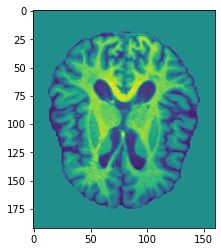

In [325]:
x, y = ds[42]

print(y)
plt.imshow(x.detach().numpy().squeeze())
plt.show()

In [331]:
torch.Tensor(12)

tensor([1.6160e+10, 4.5820e-41, 7.4249e+28, 3.0624e-41, 4.4842e-44, 0.0000e+00,
        8.9683e-44, 0.0000e+00, 7.0398e+25, 3.0624e-41, 2.5223e-44, 0.0000e+00])

In [350]:
ds[500]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 tensor([[82.]]))

In [32]:
import torch
import h5py
from torch.utils.data import Dataset

class ADNIDataset(Dataset):
    def __init__(
        self,
        hdf5_fpath,
        transform=torch.Tensor,
        dataset='train',
    ) -> None:
        super().__init__()

        hdf5_fpath = Path(hdf5_fpath)
        assert hdf5_fpath.exists()

        self._fpath = hdf5_fpath
        self.dataset = dataset

        self.transform = transform

    def __len__(self):
        with h5py.File(self._fpath, 'r') as h:
            if self.dataset == 'train+val':
                l = h['train']['y'].shape[0]
                l += h['val']['y'].shape[0]
            else:
                l = h[self.dataset]['y'].shape[0]

        return l

    def __getitem__(self, index: int):
        if self.dataset == 'train+val':
            with h5py.File(self._fpath, 'r') as h:
                train_len = h['train']['y'].shape[0]
            index_ = index - train_len

            if index_ < 0:
                dataset = 'train'
            else:
                dataset = 'val'
        else:
            index_ = index
            dataset = self.dataset

        return self._get_item(dataset, index_)

    def _get_item(self, dataset, index_):
        with h5py.File(self._fpath, 'r') as h:
            img = h[dataset]['X'][index_]
            label = h[dataset]['y'][index_]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, label

In [34]:
adni_ds = ADNIDataset('../data/interim/ADNI123_slices_fix_2mm_split.hdf5')
X, y = adni_ds[3]
X.shape

torch.Size([96, 96])

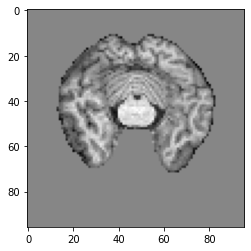

In [35]:
plt.imshow(X, cmap='gray')

# BraTS Brain Age Dataset

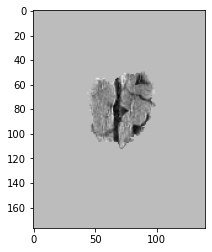

In [58]:
import pickle
brats_dir = Path('/home/jupyter/gama/nnUNet/data/processed/Task102_BraTS2020/nnUNetData_plans_v2.1_2D_stage0/')

d = np.load(next(brats_dir.glob('*.npz')))['data'][0]
plt.imshow(d[-5], cmap='gray')

In [55]:
d.shape

(141, 177, 140)

In [70]:
with open(list(brats_dir.glob('*.pkl'))[1], 'rb') as f:
    m = pickle.load(f)
m

OrderedDict([('original_size_of_raw_data', array([155, 240, 240])),
             ('original_spacing', array([1., 1., 1.])),
             ('list_of_data_files',
              ['/home/jupyter/gama/nnUNet/data/raw/nnUNet_raw_data/Task102_BraTS2020/imagesTr/BraTS20_Training_340_0000.nii.gz',
               '/home/jupyter/gama/nnUNet/data/raw/nnUNet_raw_data/Task102_BraTS2020/imagesTr/BraTS20_Training_340_0001.nii.gz',
               '/home/jupyter/gama/nnUNet/data/raw/nnUNet_raw_data/Task102_BraTS2020/imagesTr/BraTS20_Training_340_0002.nii.gz',
               '/home/jupyter/gama/nnUNet/data/raw/nnUNet_raw_data/Task102_BraTS2020/imagesTr/BraTS20_Training_340_0003.nii.gz']),
             ('seg_file',
              '/home/jupyter/gama/nnUNet/data/raw/nnUNet_raw_data/Task102_BraTS2020/labelsTr/BraTS20_Training_340.nii.gz'),
             ('itk_origin', (239.0, -0.0, 0.0)),
             ('itk_spacing', (1.0, 1.0, 1.0)),
             ('itk_direction',
              (-1.0, 0.0, 0.0, 0.0, -1.0, 0.0

In [74]:
with open('/home/jupyter/gama/nnUNet/data/processed/Task102_BraTS2020/nnUNetPlans_FabiansResUNet_v2.1_plans_2D.pkl', 'rb') as f:
    p = pickle.load(f)
patch_size = p['plans_per_stage'][0]['patch_size']
patch_size

array([192, 160])

In [64]:
import pandas as pd

pd.read_csv(brats_dir/'../../../raw/survival_info.csv').set_index('Brats20ID').iloc[5]['Age']

67.126

In [67]:
class BraTSDataset(Dataset):
    def __init__(
        self,
        imgs_dir,
        meta_fpath,
        transform=torch.Tensor,
    ) -> None:
        super().__init__()

        self.imgs_dir = Path(imgs_dir)

        assert self.imgs_dir.exists()

        self.meta = pd.read_csv(meta_fpath).set_index('Brats20ID')

        self.transform = transform

    def __len__(self):
        return self.meta.shape[0] * 80

    def __getitem__(self, index: int):
        lb = 35
        ub = 115
        
        i = index // 80
        j = index % 80

        img_id = self.meta.iloc[i].name
        label = float(self.meta.iloc[i]['Age'])

        img_meta_fpath = self.imgs_dir/f"{img_id}.pkl"
        with open(img_meta_fpath, 'rb') as f:
            img_meta = pickle.load(f)
        crop_offset = img_meta['crop_bbox'][0][0]

        full_img_fpath = self.imgs_dir/f"{img_id}.npz"
        img = np.load(full_img_fpath)['data'][0, 35 - crop_offset + j]

        # transform
        if self.transform is not None:
            img = self.transform(img)

        return img, label

ds = BraTSDataset('/home/jupyter/gama/nnUNet/data/processed/Task102_BraTS2020/nnUNetData_plans_v2.1_2D_stage0/', '/home/jupyter/gama/nnUNet/data/raw/survival_info.csv')
ds[0]

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 60.463)

In [75]:
X = ds[0][0]
X.shape

torch.Size([173, 137])

In [93]:
X.shape + pad

array([192, 160])

In [81]:
pad = patch_size - X.shape
(pad / 2).astype(int)

array([ 9, 11])

In [84]:
pad_left = (pad / 2).astype(int)
pad_right = (0.5 + pad / 2).astype(int)

f_pad = np.empty((pad_left.size + pad_right.size,), dtype=pad_left.dtype)
f_pad[0::2] = pad_left
f_pad[1::2] = pad_right
f_pad

array([ 9, 10, 11, 12])

In [94]:
from torchvision import transforms

torch.nn.functional.pad(X, f_pad.tolist()[::-1]).shape

torch.Size([192, 160])

In [91]:
patch_size

array([192, 160])